In [1]:
from HeaderP import *

In [2]:
rvs = readfits('RVSdr3.fits')
rvs.columns
rvs['source_id_int'] = np.array(rvs['source_id'], dtype=int)

In [3]:
for i in rvs.columns:
    if i == 'source_id_int':
        continue
    rvs[i]=np.array(rvs[i], dtype=float)

In [15]:
df = pd.read_csv('AllztfAge.csv')
len(df)

71537

<AxesSubplot:>

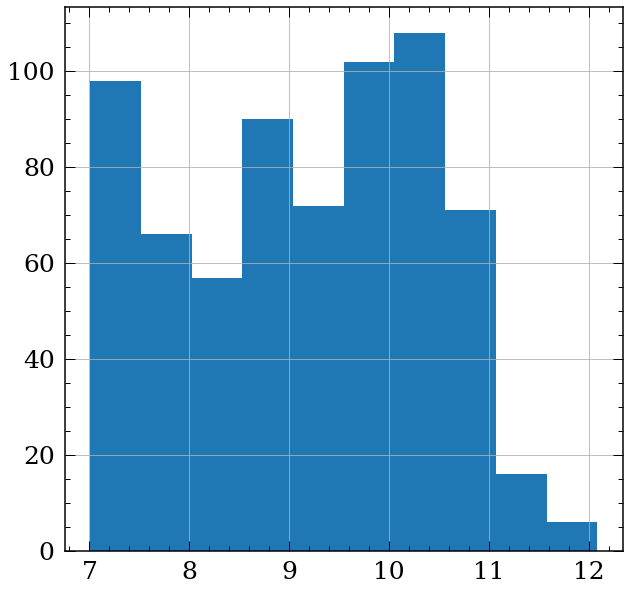

In [18]:
df['abs_G_x'].hist()

In [19]:
rvs.loc[(rvs['teff']<6000)&(rvs['abs_G']>7)]

,source_id,ra,dec,bp_rp,l,b,teff,abs_G,m_h,vmac,reduced_chi_sq,rvs_snr,source_id_int
0,4.268186e+18,288.497562,2.806955,1.228698,38.010103,-3.726936,4569.247281,11.266091,-0.068594,0.732669,1.166827,23.487396,4268186495643381632
1,4.268188e+18,288.627531,2.841828,1.504693,38.101065,-3.826076,4622.783358,8.361414,0.285995,6.636686,1.097891,23.879986,4268187595154857728
11,4.268216e+18,287.920022,2.695873,4.255877,37.645272,-3.265940,3288.377343,13.695840,-1.060913,-17.567445,1.889627,21.048073,4268216182459736576
20,4.268239e+18,287.695228,2.986015,4.963108,37.799881,-2.933138,1936.714167,13.545978,0.534018,10.513318,46.990365,22.700947,4268239031687745664
25,4.268252e+18,288.353287,3.065017,1.692719,38.173084,-3.480160,4674.059031,7.380889,0.093052,2.229309,1.098282,24.054726,4268252088389760128
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999619,1.764401e+17,66.226442,35.792446,1.176796,164.221207,-9.443201,5318.389414,9.581995,0.002290,1.231814,1.180850,24.861250,176440142739060352
999624,1.764991e+17,65.451086,35.292930,1.578734,164.143271,-10.244224,5035.678235,7.985179,0.080517,4.437735,1.066213,23.252951,176499142705689216
999625,1.765144e+17,65.538228,35.527151,1.420278,164.022475,-10.030299,5287.957302,10.342676,-0.108623,-0.275285,1.192556,23.896032,176514394132428928
999634,1.765848e+17,65.158797,35.885923,1.563369,163.543165,-10.001050,5023.809617,8.997265,-0.086565,-1.359036,1.100891,26.789015,176584797236363904


686

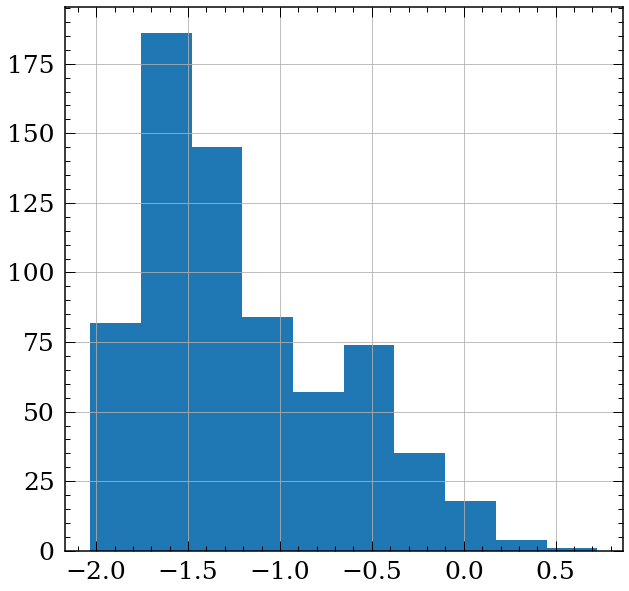

In [16]:
df = pd.merge(df, rvs, left_on='gaiaid', right_on='source_id',
             how='inner')

df['m_h'].hist()
len(df)

In [9]:
df = df.drop_duplicates('source_id_int')
len(df)

KeyError: Index(['source_id_int'], dtype='object')

In [30]:
import urllib.request
sourceids = df['source_id_int'].values
for i in trange(len(df)):  
    gaia_source_id = sourceids[i]
    #rvs
    urllib.request.urlretrieve(f"https://gea.esac.esa.int/data-server/data?ID=Gaia+DR3+{gaia_source_id}&RETRIEVAL_TYPE=RVS&format=FITS", f"MdwarfRVS/{gaia_source_id}.fits")

100%|██████████| 686/686 [08:36<00:00,  1.33it/s]


In [31]:
fitsname = ['./MdwarfRVS/'+str(i)+'.fits' for i in sourceids]


In [133]:
import os
from astropy.io import fits as pyfits
def load_spectra(data_dir):
    """ Reads wavelength, flux, and flux uncertainty data from apogee fits files

    Parameters
    ----------
    data_dir: str
        Name of the directory containing all of the data files

    Returns
    -------
    wl: ndarray
        Rest-frame wavelength vector

    fluxes: ndarray
        Flux data values

    ivars: ndarray
        Inverse variance values corresponding to flux values
    """
    print("Loading spectra from directory %s" %data_dir)
    files = list(sorted([data_dir + "/" + filename
             for filename in os.listdir(data_dir) if filename.endswith('fits')]))
    nstars = len(files)  
    for jj, fits_file in enumerate(files):
        file_in = readfits(fits_file)
        #print(file_in)
        flux = np.array(file_in['flux'], dtype=float)
        if jj == 0:
            npixels = len(flux)
            fluxes = np.zeros((nstars, npixels), dtype=float)
            ivars = np.zeros(fluxes.shape, dtype=float)
            start_wl = 846
            diff_wl = 0.01
            val = diff_wl * (npixels) + start_wl
            wl_full = np.arange(start_wl,val, diff_wl)
            wl = np.array(wl_full)
        flux_err = np.array((file_in['flux_error']), dtype=float)
        badpix = get_pixmask(flux, flux_err)
        ivar = np.zeros(npixels)
        ivar[~badpix] = 1. / flux_err[~badpix]**2
        ivar[badpix] = 10000
        flux[badpix] = 0
        fluxes[jj,:] = flux
        ivars[jj,:] = ivar
    # convert filenames to actual IDs
    names = np.array([f.split('.fits')[0].split('MdwarfRVS/')[1] for f in files])
    print("Spectra loaded")
    # make sure they are numpy arrays
    return np.array(names), np.array(wl), np.array(fluxes), np.array(ivars)


def get_pixmask(fluxes, flux_errs):
    """ Create and return a bad pixel mask for an APOGEE spectrum

    Bad pixels are defined as follows: fluxes or errors are not finite, or 
    reported errors are <= 0, or fluxes are 0

    Parameters
    ----------
    fluxes: ndarray
        Flux data values 

    flux_errs: ndarray
        Flux uncertainty data values 

    Returns
    -------
    mask: ndarray
        Bad pixel mask, value of True corresponds to bad pixels
    """
    bad_flux = np.logical_or(~np.isfinite(fluxes), np.isnan(fluxes))
    bad_err = (~np.isfinite(flux_errs)) | np.isnan(flux_errs)
    bad_pix = bad_err | bad_flux
    return bad_pix

In [134]:
tr_ID_r, wl_r, tr_flux_r, tr_ivar_r = load_spectra("MdwarfRVS")
tr_ID_r = np.array(tr_ID_r, dtype=int)

tr_ID, wl, tr_flux, tr_ivar = tr_ID_r, wl_r, tr_flux_r, tr_ivar_r

len(tr_ID)

Loading spectra from directory MdwarfRVS
Spectra loaded


685

In [137]:
tr_label=np.zeros((len(tr_ID),4))

for i in range((len(tr_ID))):
    #print(i)
    tr_label[i,:]=df.loc[df['source_id_int']==tr_ID[i]][['m_h','teff','kin_age','abs_G_x']].values
               

In [138]:
np.shape(tr_label)

(685, 4)

In [139]:
def _SNR(flux, ivar):
    """ Calculate the SNR of a spectrum, ignoring bad pixels

    Parameters
    ----------
    flux: numpy ndarray
        pixel intensities
    ivar: numpy ndarray
        inverse variances corresponding to flux

    Returns
    -------
    SNR: float
    """
    take = ivar > 0
    SNR = float(np.median(flux[take]*(ivar[take]**0.5)))
    return SNR  

In [140]:
SNR = np.array([_SNR(*s) for s in zip(tr_flux, tr_ivar)])

In [141]:
print(tr_ID.shape)
print(wl.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)


(685,)
(2401,)
(685, 2401)
(685, 2401)
(685, 4)


In [142]:
train_ID = tr_ID
train_flux = tr_flux
train_ivar = tr_ivar
train_label = tr_label

test_ID = tr_ID
test_flux = tr_flux
test_ivar = tr_ivar
test_label = tr_label

In [143]:
from TheCannon import dataset
#from importlib import reload  
#reload(dataset)

ds = dataset.Dataset(wl, train_ID, train_flux, train_ivar, train_label, 
                     test_ID, test_flux, test_ivar)



Loading dataset
This may take a while...


In [181]:
ds.set_label_names(['[Fe/H]','T_{eff}','Gyro-kinmatic Age','abs_G'])




Diagnostic for SNRs of reference and survey objects


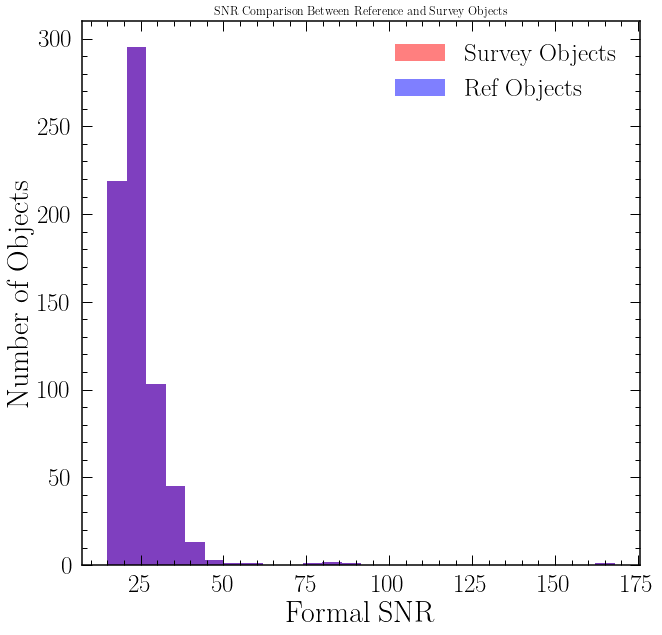

In [182]:
fig = ds.diagnostics_SNR()




Plotting every label against every other


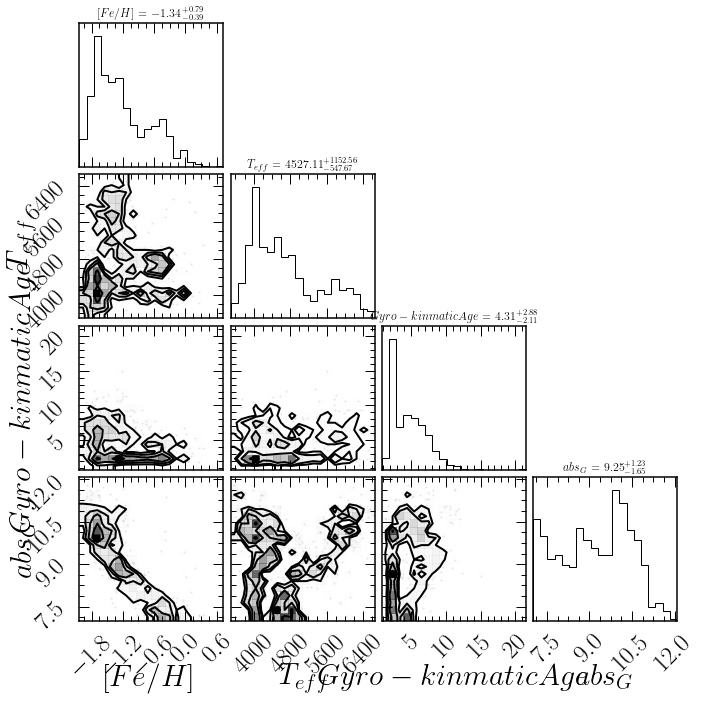

In [183]:
fig = ds.diagnostics_ref_labels()

In [184]:
from TheCannon import model
md = model.CannonModel(2, useErrors=False)
md.fit(ds)

Done training model. 


Diagnostic plot: leading coeffs and scatters across wavelength.


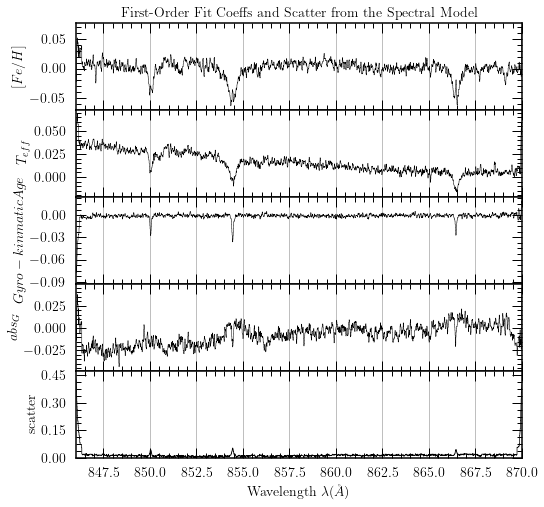

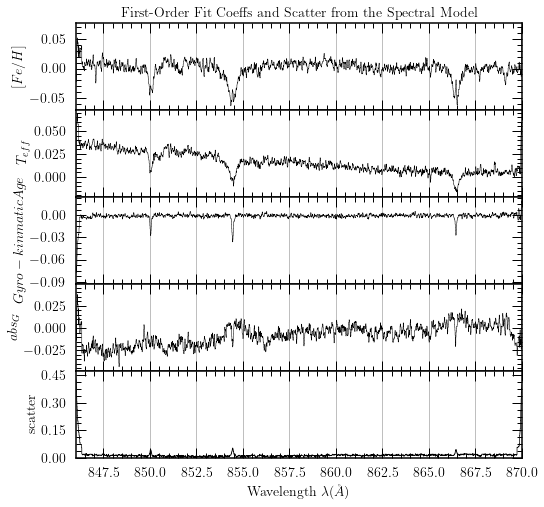

In [185]:
md.diagnostics_leading_coeffs(ds)

In [186]:
label_errs = md.infer_labels(ds)

Inferring Labels


In [187]:
test_labels = ds.test_label_vals
ds.tr_label=test_label

In [200]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from HeaderP import *
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   }
plt.rcParams.update(params)

def fitpoints(x,y):
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    return p

import matplotlib.gridspec as gridspec
def diagnostics_1to1(ds, figname="1to1_label"):
        """ Plots survey labels vs. training labels, color-coded by survey SNR """
        label_names = ds.get_plotting_labels()
        nlabels = len(label_names)
        print(nlabels)
        reference_labels = ds.tr_label
        test_labels = ds.test_label_vals

        for i in range(nlabels):
            snr = ds.test_SNR
            name = label_names[i]
            orig = reference_labels[:,i]
            cannon = test_labels[:,i]
            
            '''
            m1=cannon>-500
            m2=orig>-500
            m=m1&m2
            
            orig, cannon, snr=orig[m],cannon[m],snr[m]
            '''
            # calculate bias and scatter
            scatter = np.round(np.std(orig-cannon),5)
            bias  = np.round(np.mean(orig-cannon),5)

            low = np.minimum(min(orig), min(cannon))
            high = np.maximum(max(orig), max(cannon))

            fig = plt.figure(figsize=(10,6))
            gs = gridspec.GridSpec(1,2,width_ratios=[2,1], wspace=0.3)
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            ax1.plot([low, high], [low, high], 'k-', linewidth=2.0, label="x=y")
            ax1.set_xlim(low, high)
            ax1.set_ylim(low, high)
            ax1.legend(fontsize=14, loc='lower right')

            pl = ax1.scatter(orig, cannon, marker='x', c=snr,
                    vmin=10, vmax=30, alpha=0.7)
            cb = plt.colorbar(pl, ax=ax1, orientation='horizontal')
            cb.set_label('SNR from Test Set', fontsize=12)
            textstr = 'Scatter: %s \nBias: %s' %(scatter, bias)
            ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                    fontsize=14, verticalalignment='top')
            ax1.tick_params(axis='x', labelsize=14)
            ax1.tick_params(axis='y', labelsize=14)
            ax1.set_xlabel("Gyro-Kinematic Age [Gyr]", fontsize=14)
            ax1.set_ylabel("Cannon Age [Gyr]", fontsize=14)
            ax1.set_title("1-1 Plot of Label " + "%s" % name)
            diff = cannon-orig
            npoints = len(diff)
            mu = np.mean(diff)
            sig = np.std(diff)
            #ax2.hist(diff, orientation='horizontal')
            ax2.hist(diff, range=[-3*sig,3*sig], color='k', bins=int(np.sqrt(npoints)),
                    orientation='horizontal', alpha=0.3, histtype='stepfilled')
            ax2.tick_params(axis='x', labelsize=14)
            ax2.tick_params(axis='y', labelsize=14)
            ax2.set_xlabel("Count", fontsize=14)
            ax2.set_ylabel("Difference", fontsize=14)
            ax2.axhline(y=0, c='k', lw=3, label='Difference=0')
            ax2.set_title("Training Versus Test Labels for %s" %name,
                    fontsize=14)
            ax2.legend(fontsize=14)
            figname_full = "%s_%s.png" %(figname, i)
            plt.savefig(figname_full)





4


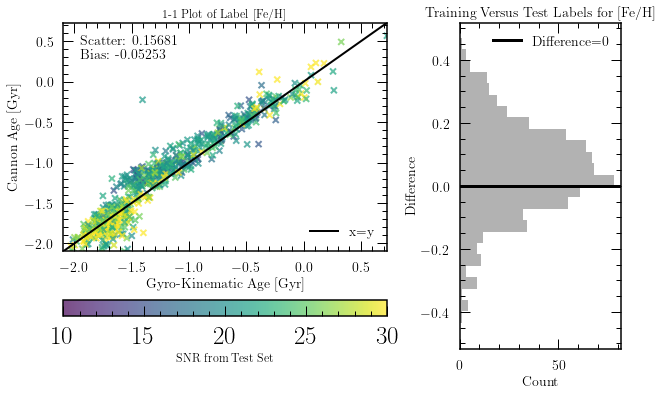

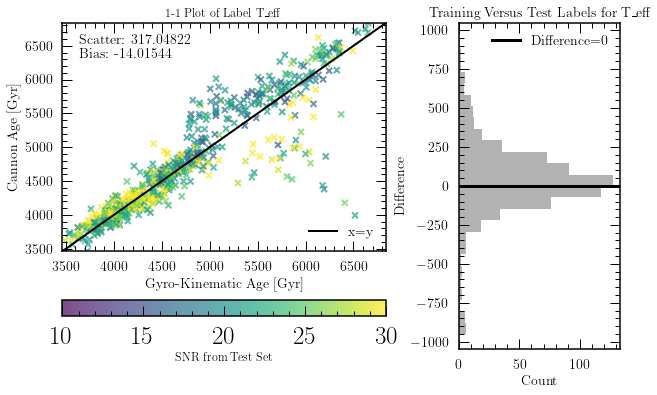

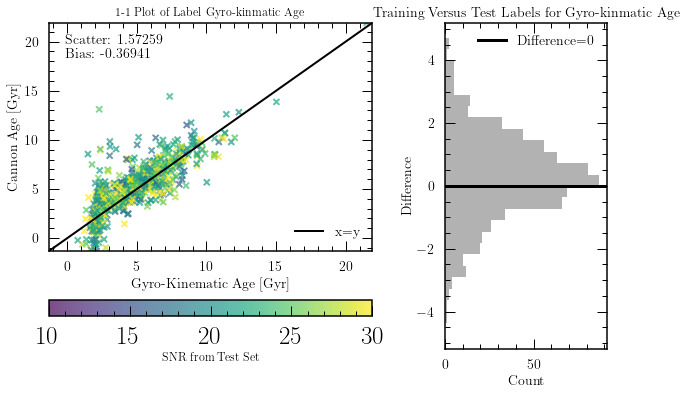

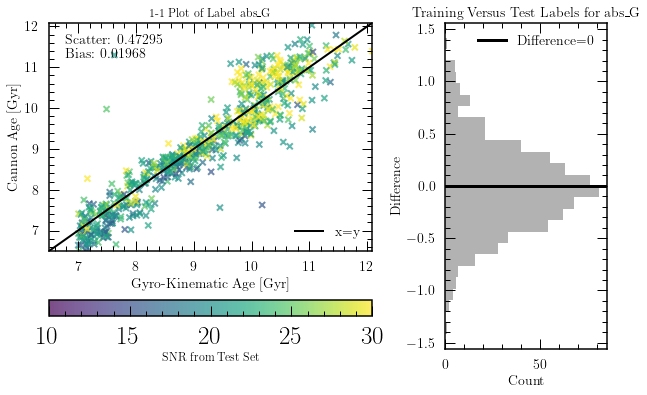

In [201]:
# with more stars 
diagnostics_1to1(ds)